# This notebook plots MCS rain rate as a function of PWV from different trackers
## The data is produced by:
- /src/calc_mcs_pcp_envs_pairs.py
### Also requires regridding pixel-level data by:
- /src/regrid_tbpcp2era5.py
- /src/regrid_mcsmask2era5.py
- /src/regrid_envs2era5.py

In [1]:
import numpy as np
import xarray as xr
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import copy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings
%matplotlib inline

In [2]:
PHASE = 'Summer'
# PHASE = 'Winter'

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/'
dir_PyFLEXTRKR = f'{rootdir}PyFLEXTRKR/'
dir_MOAAP = f'{rootdir}MOAAP/'
dir_TOOCAN = f'{rootdir}TOOCAN/'
dir_tobac = f'{rootdir}tobac/'
dir_TAMS = f'{rootdir}TAMS/'
dir_simpleTrack = f'{rootdir}simpleTrack/'
dir_DL = f'{rootdir}DL/'
dir_KFyAO = f'{rootdir}KFyAO/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'obsv7': 'OBSv7',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        'm12': 'SCREAMv1',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'obsv7': 'OBSv7',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
        'm12': 'SCREAMv1',
    }

# Input files
envfiles_PyFLEXTRKR = {key:f'{dir_PyFLEXTRKR}mcs_intqv_{PHASE}_{value}.nc' for key,value in name_map.items()}
envfiles_MOAAP = {key:f'{dir_MOAAP}mcs_intqv_{PHASE}_{value}.nc' for key,value in name_map.items()}
envfiles_TOOCAN = {key:f'{dir_TOOCAN}mcs_intqv_{PHASE}_{value}.nc' for key,value in name_map.items()}
envfiles_tobac = {key:f'{dir_tobac}mcs_intqv_{PHASE}_{value}.nc' for key,value in name_map.items()}
envfiles_TAMS = {key:f'{dir_TAMS}mcs_intqv_{PHASE}_{value}.nc' for key,value in name_map.items()}
envfiles_simpleTrack = {key:f'{dir_simpleTrack}mcs_intqv_{PHASE}_{value}.nc' for key,value in name_map.items()}
envfiles_DL = {key:f'{dir_DL}mcs_intqv_{PHASE}_{value}.nc' for key,value in name_map.items()}
envfiles_KFyAO = {key:f'{dir_KFyAO}mcs_intqv_{PHASE}_{value}.nc' for key,value in name_map.items()}
# Interquartile values for OBS
qrtfiles = {
    'PyFLEXTRKR': f'{dir_PyFLEXTRKR}mcs_intqv_{PHASE}_OBS_quartile.nc',
    'MOAAP': f'{dir_MOAAP}mcs_intqv_{PHASE}_OBS_quartile.nc',
    'TOOCAN': f'{dir_TOOCAN}mcs_intqv_{PHASE}_OBS_quartile.nc',
    'tobac': f'{dir_tobac}mcs_intqv_{PHASE}_OBS_quartile.nc',
    'TAMS': f'{dir_TAMS}mcs_intqv_{PHASE}_OBS_quartile.nc',
    'simpleTrack': f'{dir_simpleTrack}mcs_intqv_{PHASE}_OBS_quartile.nc',
    'DL': f'{dir_DL}mcs_intqv_{PHASE}_OBS_quartile.nc',
    'KFyAO': f'{dir_KFyAO}mcs_intqv_{PHASE}_OBS_quartile.nc'
}
tracker_list = list(qrtfiles.keys())

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/MCSMIP/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/


In [3]:
tracker_list

['PyFLEXTRKR',
 'MOAAP',
 'TOOCAN',
 'tobac',
 'TAMS',
 'simpleTrack',
 'DL',
 'KFyAO']

## Check if input files exist

In [4]:
for key, value in qrtfiles.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_intqv_Summer_OBS_quartile.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_intqv_Summer_OBS_quartile.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_intqv_Summer_OBS_quartile.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_intqv_Summer_OBS_quartile.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_intqv_Summer_OBS_quartile.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_intqv_Summer_OBS_quartile.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_intqv_Summer_OBS_quartile.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_intqv_Summer_OBS_quartile.nc: True


In [5]:
for key, value in envfiles_PyFLEXTRKR.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_intqv_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_intqv_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_intqv_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_intqv_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_intqv_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_intqv_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_intqv_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_intqv_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_intqv_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_intqv_Summer_SCREAMv1.nc: True


In [6]:
for key, value in envfiles_MOAAP.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_intqv_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_intqv_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_intqv_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_intqv_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_intqv_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_intqv_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_intqv_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_intqv_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_intqv_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_intqv_Summer_SCREAMv1.nc: True


In [7]:
for key, value in envfiles_TOOCAN.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_intqv_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_intqv_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_intqv_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_intqv_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_intqv_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_intqv_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_intqv_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_intqv_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_intqv_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_intqv_Summer_SCREAMv1.nc: True


In [8]:
for key, value in envfiles_tobac.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_intqv_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_intqv_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_intqv_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_intqv_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_intqv_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_intqv_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_intqv_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_intqv_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_intqv_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_intqv_Summer_SCREAMv1.nc: True


In [9]:
for key, value in envfiles_TAMS.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_intqv_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_intqv_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_intqv_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_intqv_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_intqv_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_intqv_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_intqv_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_intqv_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_intqv_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_intqv_Summer_SCREAMv1.nc: True


In [10]:
for key, value in envfiles_simpleTrack.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_intqv_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_intqv_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_intqv_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_intqv_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_intqv_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_intqv_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_intqv_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_intqv_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_intqv_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_intqv_Summer_SCREAMv1.nc: True


In [11]:
for key, value in envfiles_DL.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_intqv_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_intqv_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_intqv_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_intqv_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_intqv_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_intqv_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_intqv_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_intqv_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_intqv_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_intqv_Summer_SCREAMv1.nc: True


In [12]:
for key, value in envfiles_KFyAO.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_intqv_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_intqv_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_intqv_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_intqv_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_intqv_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_intqv_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_intqv_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_intqv_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_intqv_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_intqv_Summer_SCREAMv1.nc: True


## Read data

In [13]:
# Read all files and combine them
dse_qrt = xr.open_mfdataset(list(qrtfiles.values()), combine='nested', concat_dim='tracker').load()
# Assign new coordinate 'tracker'
dse_qrt['tracker'] = tracker_list
dse_qrt

<xarray.Dataset>
Dimensions:       (tracker: 8, bins: 44)
Coordinates:
  * bins          (bins) float64 6.0 8.0 10.0 12.0 14.0 ... 86.0 88.0 90.0 92.0
  * tracker       (tracker) <U11 'PyFLEXTRKR' 'MOAAP' 'TOOCAN' ... 'DL' 'KFyAO'
Data variables:
    mcs_ocean_25  (tracker, bins) float64 nan nan nan nan ... 3.37 5.207 6.433
    mcs_ocean_75  (tracker, bins) float64 nan nan nan nan ... 12.45 15.46 24.24
    mcs_land_25   (tracker, bins) float64 0.05526 0.03559 0.03651 ... nan nan
    mcs_land_75   (tracker, bins) float64 0.7311 0.7669 0.7279 ... nan nan nan
Attributes:
    title:             Precipitation by environments interquartile values
    lon_bounds:        [-180  180]
    lat_bounds:        [-15  30]
    landfrac_thresh:   0.9
    oceanfrac_thresh:  0.0
    contact:           Zhe Feng, zhe.feng@pnnl.gov
    created_on:        Sat May  4 13:32:59 2024

In [14]:
# Read all files and combine them
dse_pyflex = xr.open_mfdataset(list(envfiles_PyFLEXTRKR.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
dse_pyflex['source'] = list(name_map.keys())
dse_pyflex

<xarray.Dataset>
Dimensions:         (source: 10, bins: 44)
Coordinates:
  * bins            (bins) float64 6.0 8.0 10.0 12.0 ... 86.0 88.0 90.0 92.0
  * source          (source) <U5 'obs' 'obsv7' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables:
    total_land      (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    mcs_land        (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    total_ocean     (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    mcs_ocean       (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    total_land_ns   (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    mcs_land_ns     (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    total_ocean_ns  (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    mcs_ocean_ns    (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
Attributes:
    title:             Precipitation by environments
    lon_bounds:        [-180  180]
    lat_bounds:        [-15  30]
    landfrac_thresh:   0.9
    oceanfrac_thresh:  0.0
    contact:           Zhe Feng, zhe.feng@pnnl.gov
    created_on:        Sat May  4 13:27:51 2024

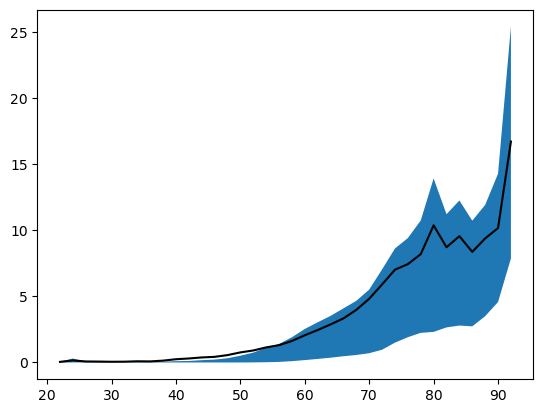

In [15]:
bins = dse_qrt.bins
q25 = dse_qrt.sel(tracker='PyFLEXTRKR').mcs_ocean_25
q75 = dse_qrt.sel(tracker='PyFLEXTRKR').mcs_ocean_75
avg = dse_pyflex.sel(source='obs').mcs_ocean
plt.fill_between(bins, q25, q75)
plt.plot(bins, avg, color='k')

In [16]:
# Read all files and combine them
dse_moaap = xr.open_mfdataset(list(envfiles_MOAAP.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
dse_moaap['source'] = list(name_map.keys())

In [17]:
# Read all files and combine them
dse_toocan = xr.open_mfdataset(list(envfiles_TOOCAN.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
dse_toocan['source'] = list(name_map.keys())

In [18]:
# Read all files and combine them
dse_tobac = xr.open_mfdataset(list(envfiles_tobac.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
dse_tobac['source'] = list(name_map.keys())

In [19]:
# Read all files and combine them
dse_tams = xr.open_mfdataset(list(envfiles_TAMS.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
dse_tams['source'] = list(name_map.keys())

In [20]:
# Read all files and combine them
dse_simtrack = xr.open_mfdataset(list(envfiles_simpleTrack.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
dse_simtrack['source'] = list(name_map.keys())

In [21]:
# Read all files and combine them
dse_dl = xr.open_mfdataset(list(envfiles_DL.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
dse_dl['source'] = list(name_map.keys())

In [22]:
# Read all files and combine them
dse_kfyao = xr.open_mfdataset(list(envfiles_KFyAO.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
dse_kfyao['source'] = list(name_map.keys())
dse_kfyao

<xarray.Dataset>
Dimensions:         (source: 10, bins: 44)
Coordinates:
  * bins            (bins) float64 6.0 8.0 10.0 12.0 ... 86.0 88.0 90.0 92.0
  * source          (source) <U5 'obs' 'obsv7' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables:
    total_land      (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    mcs_land        (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    total_ocean     (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    mcs_ocean       (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    total_land_ns   (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    mcs_land_ns     (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    total_ocean_ns  (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    mcs_ocean_ns    (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
Attributes:
    title:             Precipitation by environments
    lon_bounds:        [-180  180]
    lat_bounds:        [-15  30]
    landfrac_thresh:   0.9
    oceanfrac_thresh:  0.0
    contact:           Zhe Feng, zhe.feng@pnnl.gov
    created_on:        Mon May 20 14:25:57 2024

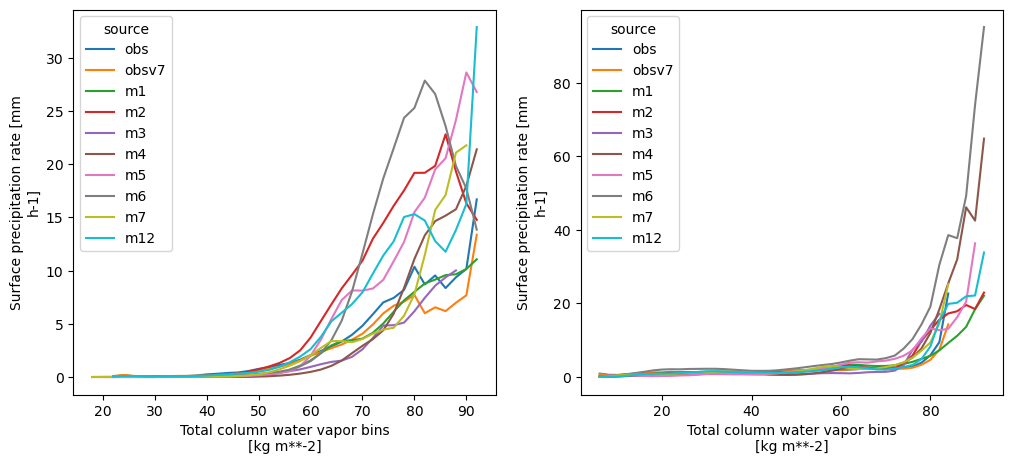

In [23]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
dse_pyflex.mcs_ocean.plot.line(x='bins', ax=axes[0])
dse_pyflex.mcs_land.plot.line(x='bins', ax=axes[1])

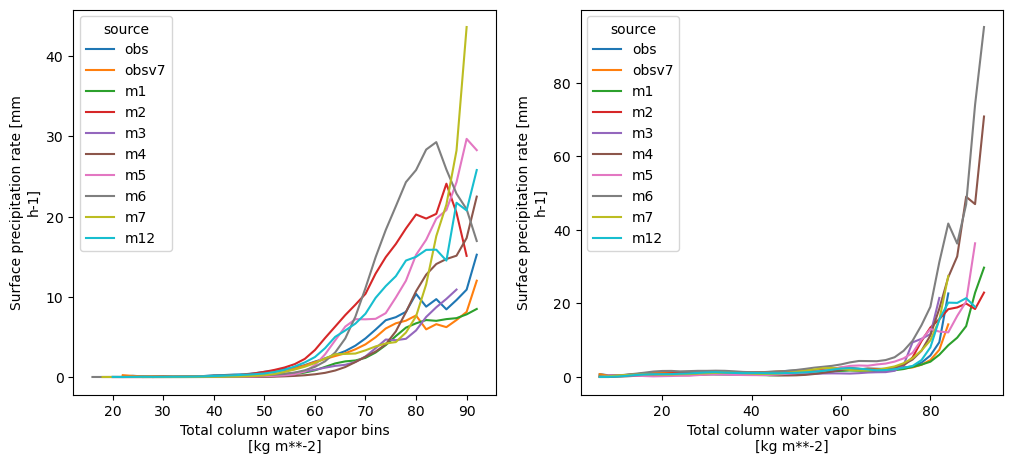

In [24]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
dse_kfyao.mcs_ocean.plot.line(x='bins', ax=axes[0])
dse_kfyao.mcs_land.plot.line(x='bins', ax=axes[1])

In [25]:
# Min pdf threshold
min_pdf_thresh = 1e-4
# min_pdf_thresh = 1e-6

In [26]:
# Normalize the number of samples in each bin by the total sample
mcs_ocean_ns_pyflex = dse_pyflex.mcs_ocean_ns
total_ocean_ns_pyflex = dse_pyflex.total_ocean_ns
mcs_ocean_pdf_pyflex = mcs_ocean_ns_pyflex / mcs_ocean_ns_pyflex.sum(dim='bins')
total_ocean_pdf_pyflex = total_ocean_ns_pyflex / total_ocean_ns_pyflex.sum(dim='bins')

# Filter bins with insufficient samples
mcs_ocean_pyflex = dse_pyflex.mcs_ocean.where(mcs_ocean_pdf_pyflex > min_pdf_thresh)
total_ocean_pyflex = dse_pyflex.total_ocean.where(total_ocean_pdf_pyflex > min_pdf_thresh)

# Normalize the number of samples in each bin by the total sample
mcs_land_ns_pyflex = dse_pyflex.mcs_land_ns
total_land_ns_pyflex = dse_pyflex.total_land_ns
mcs_land_pdf_pyflex = mcs_land_ns_pyflex / mcs_land_ns_pyflex.sum(dim='bins')
total_land_pdf_pyflex = total_land_ns_pyflex / total_land_ns_pyflex.sum(dim='bins')

# Filter bins with insufficient samples
mcs_land_pyflex = dse_pyflex.mcs_land.where(mcs_land_pdf_pyflex > min_pdf_thresh)
total_land_pyflex = dse_pyflex.total_land.where(total_land_pdf_pyflex > min_pdf_thresh)

# Filter interquartile value bins with insufficient samples
mcs_ocean25_pyflex = dse_qrt.sel(tracker='PyFLEXTRKR').mcs_ocean_25.where(mcs_ocean_pdf_pyflex.sel(source='obs') > min_pdf_thresh)
mcs_ocean75_pyflex = dse_qrt.sel(tracker='PyFLEXTRKR').mcs_ocean_75.where(mcs_ocean_pdf_pyflex.sel(source='obs') > min_pdf_thresh)
mcs_land25_pyflex = dse_qrt.sel(tracker='PyFLEXTRKR').mcs_land_25.where(mcs_land_pdf_pyflex.sel(source='obs') > min_pdf_thresh)
mcs_land75_pyflex = dse_qrt.sel(tracker='PyFLEXTRKR').mcs_land_75.where(mcs_land_pdf_pyflex.sel(source='obs') > min_pdf_thresh)

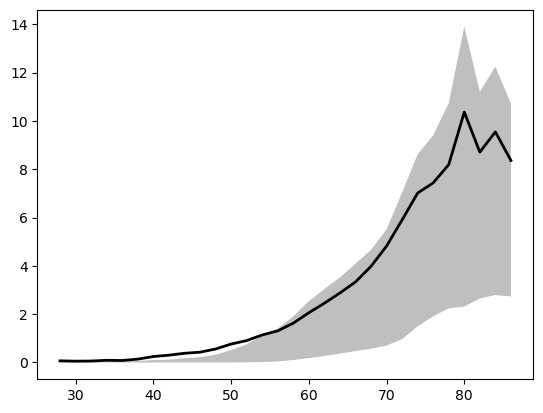

In [27]:
plt.fill_between(bins, mcs_ocean25_pyflex, mcs_ocean75_pyflex, facecolor='gray', alpha=0.5)
plt.plot(bins, mcs_ocean_pyflex.sel(source='obs'), lw=2, color='k')

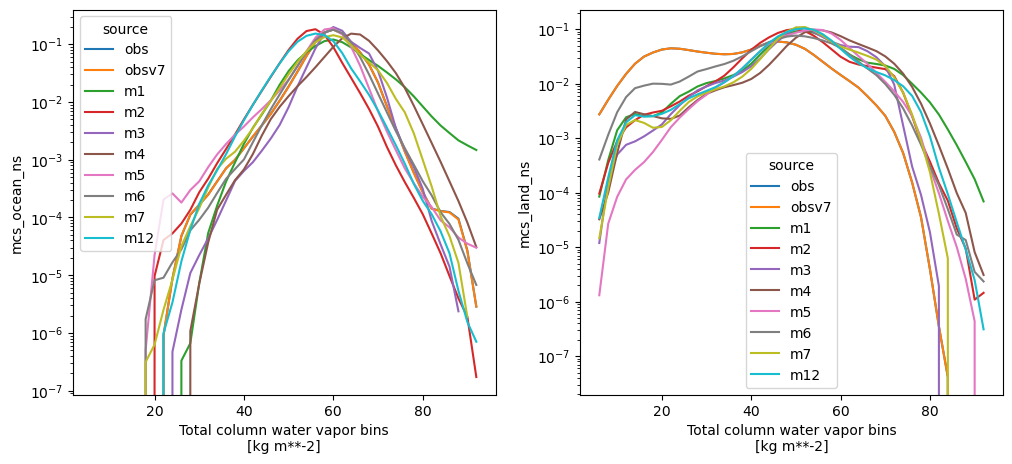

In [28]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
mcs_ocean_pdf_pyflex.plot.line(x='bins', ax=axes[0])
mcs_land_pdf_pyflex.plot.line(x='bins', ax=axes[1])
axes[0].set_yscale('log')
axes[1].set_yscale('log')

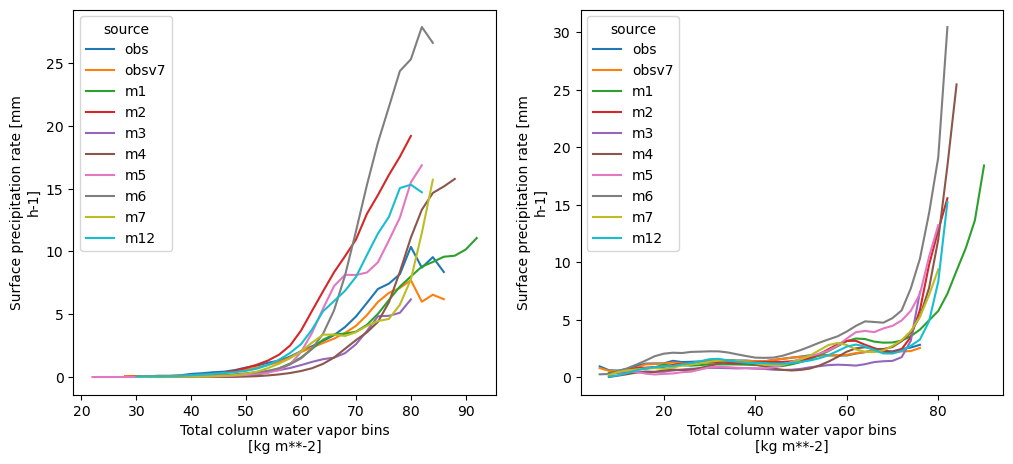

In [29]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
mcs_ocean_pyflex.plot.line(x='bins', ax=axes[0])
mcs_land_pyflex.plot.line(x='bins', ax=axes[1])

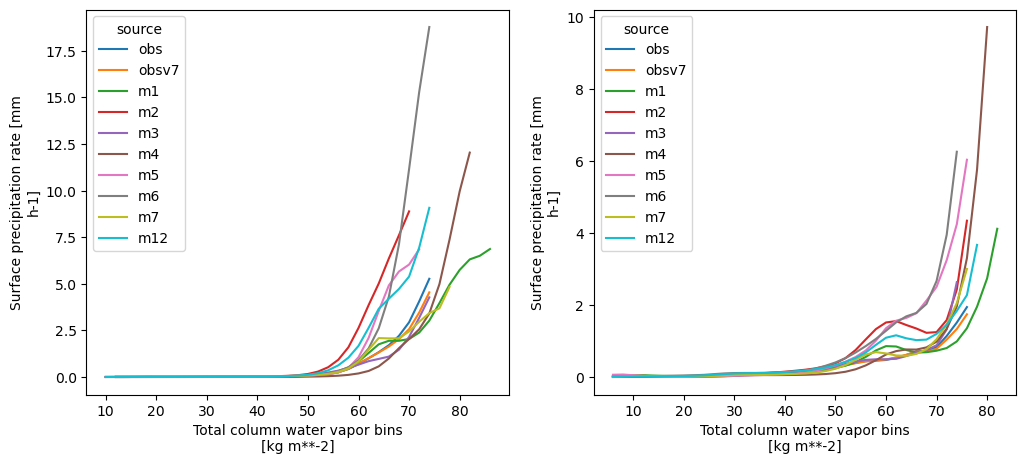

In [30]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
total_ocean_pyflex.plot.line(x='bins', ax=axes[0])
total_land_pyflex.plot.line(x='bins', ax=axes[1])

In [31]:
# Normalize the number of samples in each bin by the total sample
mcs_ocean_ns_moaap = dse_moaap.mcs_ocean_ns
total_ocean_ns_moaap = dse_moaap.total_ocean_ns
mcs_ocean_pdf_moaap = mcs_ocean_ns_moaap / mcs_ocean_ns_moaap.sum(dim='bins')
total_ocean_pdf_moaap = total_ocean_ns_moaap / total_ocean_ns_moaap.sum(dim='bins')

# Filter bins with insufficient samples
mcs_ocean_moaap = dse_moaap.mcs_ocean.where(mcs_ocean_pdf_moaap > min_pdf_thresh)
total_ocean_moaap = dse_moaap.total_ocean.where(total_ocean_pdf_moaap > min_pdf_thresh)

# Normalize the number of samples in each bin by the total sample
mcs_land_ns_moaap = dse_moaap.mcs_land_ns
total_land_ns_moaap = dse_moaap.total_land_ns
mcs_land_pdf_moaap = mcs_land_ns_moaap / mcs_land_ns_moaap.sum(dim='bins')
total_land_pdf_moaap = total_land_ns_moaap / total_land_ns_moaap.sum(dim='bins')

# Filter bins with insufficient samples
mcs_land_moaap = dse_moaap.mcs_land.where(mcs_land_pdf_moaap > min_pdf_thresh)
total_land_moaap = dse_moaap.total_land.where(total_land_pdf_moaap > min_pdf_thresh)

# Filter interquartile value bins with insufficient samples
mcs_ocean25_moaap = dse_qrt.sel(tracker='MOAAP').mcs_ocean_25.where(mcs_ocean_pdf_moaap.sel(source='obs') > min_pdf_thresh)
mcs_ocean75_moaap = dse_qrt.sel(tracker='MOAAP').mcs_ocean_75.where(mcs_ocean_pdf_moaap.sel(source='obs') > min_pdf_thresh)
mcs_land25_moaap = dse_qrt.sel(tracker='MOAAP').mcs_land_25.where(mcs_land_pdf_moaap.sel(source='obs') > min_pdf_thresh)
mcs_land75_moaap = dse_qrt.sel(tracker='MOAAP').mcs_land_75.where(mcs_land_pdf_moaap.sel(source='obs') > min_pdf_thresh)

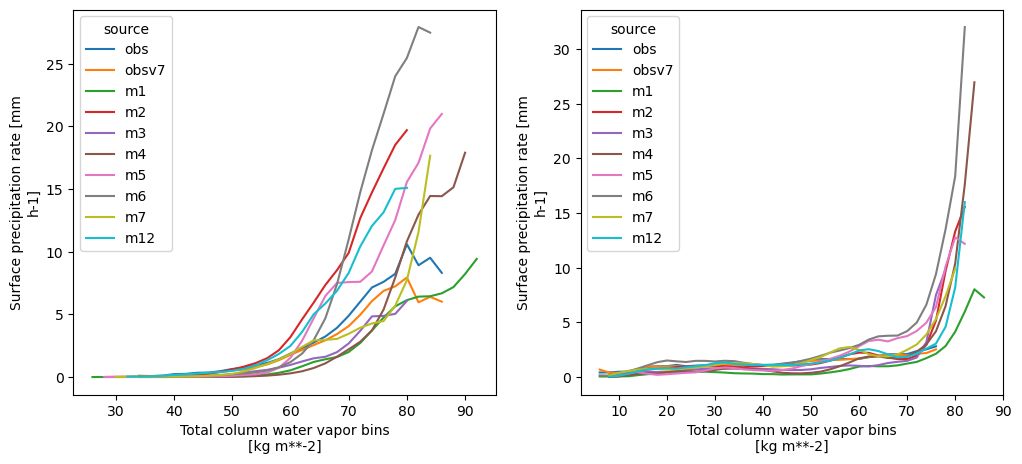

In [32]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
mcs_ocean_moaap.plot.line(x='bins', ax=axes[0])
mcs_land_moaap.plot.line(x='bins', ax=axes[1])

In [33]:
# Normalize the number of samples in each bin by the total sample
mcs_ocean_ns_toocan = dse_toocan.mcs_ocean_ns
total_ocean_ns_toocan = dse_toocan.total_ocean_ns
mcs_ocean_pdf_toocan = mcs_ocean_ns_toocan / mcs_ocean_ns_toocan.sum(dim='bins')
total_ocean_pdf_toocan = total_ocean_ns_toocan / total_ocean_ns_toocan.sum(dim='bins')

# Filter bins with insufficient samples
mcs_ocean_toocan = dse_toocan.mcs_ocean.where(mcs_ocean_pdf_toocan > min_pdf_thresh)
total_ocean_toocan = dse_toocan.total_ocean.where(total_ocean_pdf_toocan > min_pdf_thresh)

# Normalize the number of samples in each bin by the total sample
mcs_land_ns_toocan = dse_toocan.mcs_land_ns
total_land_ns_toocan = dse_toocan.total_land_ns
mcs_land_pdf_toocan = mcs_land_ns_toocan / mcs_land_ns_toocan.sum(dim='bins')
total_land_pdf_toocan = total_land_ns_toocan / total_land_ns_toocan.sum(dim='bins')

# Filter bins with insufficient samples
mcs_land_toocan = dse_toocan.mcs_land.where(mcs_land_pdf_toocan > min_pdf_thresh)
total_land_toocan = dse_toocan.total_land.where(total_land_pdf_toocan > min_pdf_thresh)

# Filter interquartile value bins with insufficient samples
mcs_ocean25_toocan = dse_qrt.sel(tracker='TOOCAN').mcs_ocean_25.where(mcs_ocean_pdf_toocan.sel(source='obs') > min_pdf_thresh)
mcs_ocean75_toocan = dse_qrt.sel(tracker='TOOCAN').mcs_ocean_75.where(mcs_ocean_pdf_toocan.sel(source='obs') > min_pdf_thresh)
mcs_land25_toocan = dse_qrt.sel(tracker='TOOCAN').mcs_land_25.where(mcs_land_pdf_toocan.sel(source='obs') > min_pdf_thresh)
mcs_land75_toocan = dse_qrt.sel(tracker='TOOCAN').mcs_land_75.where(mcs_land_pdf_toocan.sel(source='obs') > min_pdf_thresh)

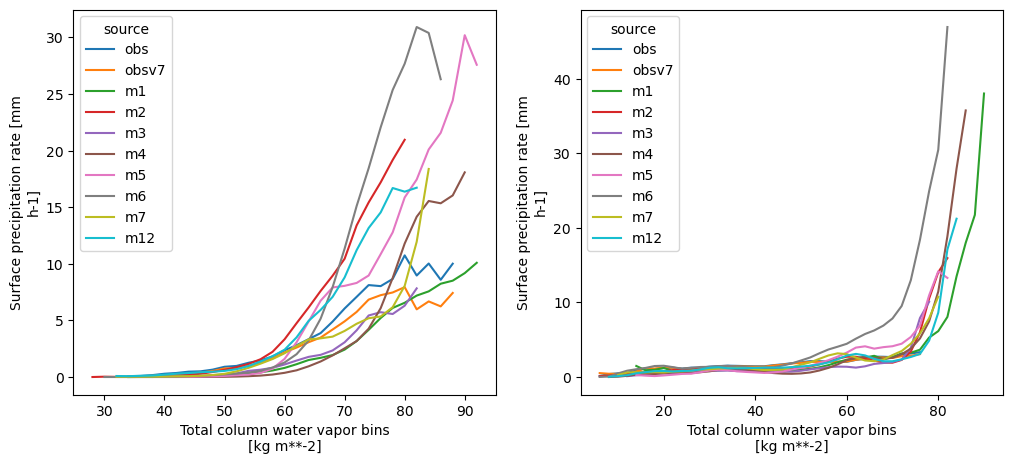

In [34]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
mcs_ocean_toocan.plot.line(x='bins', ax=axes[0])
mcs_land_toocan.plot.line(x='bins', ax=axes[1])

In [35]:
# Normalize the number of samples in each bin by the total sample
mcs_ocean_ns_tobac = dse_tobac.mcs_ocean_ns
total_ocean_ns_tobac = dse_tobac.total_ocean_ns
mcs_ocean_pdf_tobac = mcs_ocean_ns_tobac / mcs_ocean_ns_tobac.sum(dim='bins')
total_ocean_pdf_tobac = total_ocean_ns_tobac / total_ocean_ns_tobac.sum(dim='bins')

# Filter bins with insufficient samples
mcs_ocean_tobac = dse_tobac.mcs_ocean.where(mcs_ocean_pdf_tobac > min_pdf_thresh)
total_ocean_tobac = dse_tobac.total_ocean.where(total_ocean_pdf_tobac > min_pdf_thresh)

# Normalize the number of samples in each bin by the total sample
mcs_land_ns_tobac = dse_tobac.mcs_land_ns
total_land_ns_tobac = dse_tobac.total_land_ns
mcs_land_pdf_tobac = mcs_land_ns_tobac / mcs_land_ns_tobac.sum(dim='bins')
total_land_pdf_tobac = total_land_ns_tobac / total_land_ns_tobac.sum(dim='bins')

# Filter bins with insufficient samples
mcs_land_tobac = dse_tobac.mcs_land.where(mcs_land_pdf_tobac > min_pdf_thresh)
total_land_tobac = dse_tobac.total_land.where(total_land_pdf_tobac > min_pdf_thresh)

# Filter interquartile value bins with insufficient samples
mcs_ocean25_tobac = dse_qrt.sel(tracker='tobac').mcs_ocean_25.where(mcs_ocean_pdf_tobac.sel(source='obs') > min_pdf_thresh)
mcs_ocean75_tobac = dse_qrt.sel(tracker='tobac').mcs_ocean_75.where(mcs_ocean_pdf_tobac.sel(source='obs') > min_pdf_thresh)
mcs_land25_tobac = dse_qrt.sel(tracker='tobac').mcs_land_25.where(mcs_land_pdf_tobac.sel(source='obs') > min_pdf_thresh)
mcs_land75_tobac = dse_qrt.sel(tracker='tobac').mcs_land_75.where(mcs_land_pdf_tobac.sel(source='obs') > min_pdf_thresh)

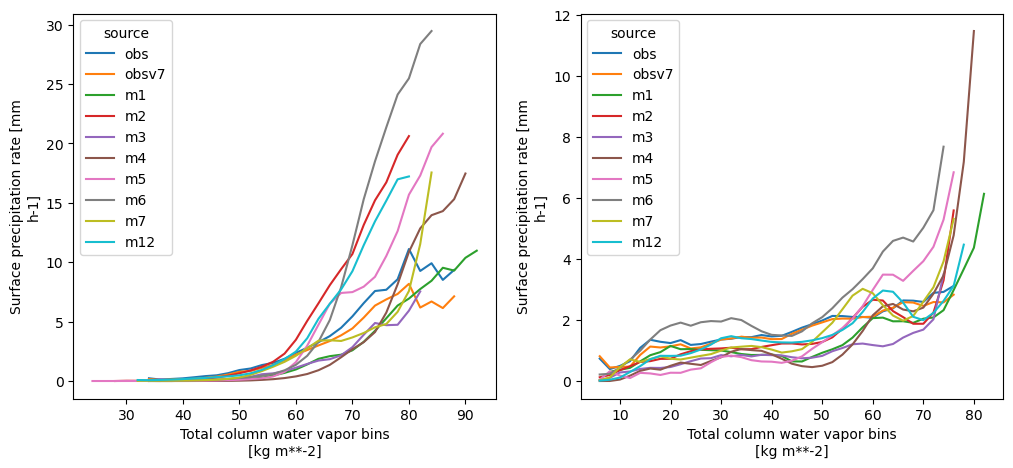

In [36]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
mcs_ocean_tobac.plot.line(x='bins', ax=axes[0])
mcs_land_tobac.plot.line(x='bins', ax=axes[1])

In [37]:
# Normalize the number of samples in each bin by the total sample
mcs_ocean_ns_tams = dse_tams.mcs_ocean_ns
total_ocean_ns_tams = dse_tams.total_ocean_ns
mcs_ocean_pdf_tams = mcs_ocean_ns_tams / mcs_ocean_ns_tams.sum(dim='bins')
total_ocean_pdf_tams = total_ocean_ns_tams / total_ocean_ns_tams.sum(dim='bins')

# Filter bins with insufficient samples
mcs_ocean_tams = dse_tams.mcs_ocean.where(mcs_ocean_pdf_tams > min_pdf_thresh)
total_ocean_tams = dse_tams.total_ocean.where(total_ocean_pdf_tams > min_pdf_thresh)

# Normalize the number of samples in each bin by the total sample
mcs_land_ns_tams = dse_tams.mcs_land_ns
total_land_ns_tams = dse_tams.total_land_ns
mcs_land_pdf_tams = mcs_land_ns_tams / mcs_land_ns_tams.sum(dim='bins')
total_land_pdf_tams = total_land_ns_tams / total_land_ns_tams.sum(dim='bins')

# Filter bins with insufficient samples
mcs_land_tams = dse_tams.mcs_land.where(mcs_land_pdf_tams > min_pdf_thresh)
total_land_tams = dse_tams.total_land.where(total_land_pdf_tams > min_pdf_thresh)

# Filter interquartile value bins with insufficient samples
mcs_ocean25_tams = dse_qrt.sel(tracker='TAMS').mcs_ocean_25.where(mcs_ocean_pdf_tams.sel(source='obs') > min_pdf_thresh)
mcs_ocean75_tams = dse_qrt.sel(tracker='TAMS').mcs_ocean_75.where(mcs_ocean_pdf_tams.sel(source='obs') > min_pdf_thresh)
mcs_land25_tams = dse_qrt.sel(tracker='TAMS').mcs_land_25.where(mcs_land_pdf_tams.sel(source='obs') > min_pdf_thresh)
mcs_land75_tams = dse_qrt.sel(tracker='TAMS').mcs_land_75.where(mcs_land_pdf_tams.sel(source='obs') > min_pdf_thresh)

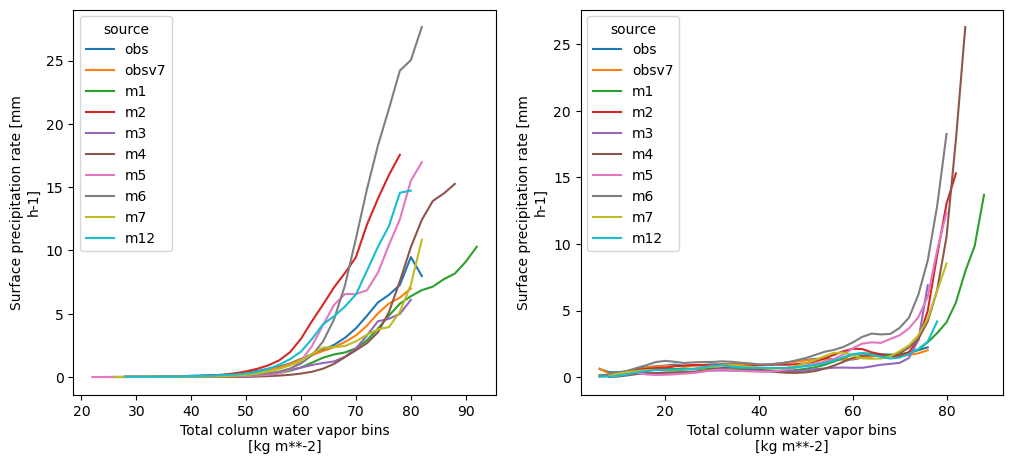

In [38]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
mcs_ocean_tams.plot.line(x='bins', ax=axes[0])
mcs_land_tams.plot.line(x='bins', ax=axes[1])

In [39]:
# Normalize the number of samples in each bin by the total sample
mcs_ocean_ns_simtrack = dse_simtrack.mcs_ocean_ns
total_ocean_ns_simtrack = dse_simtrack.total_ocean_ns
mcs_ocean_pdf_simtrack = mcs_ocean_ns_simtrack / mcs_ocean_ns_simtrack.sum(dim='bins')
total_ocean_pdf_simtrack = total_ocean_ns_simtrack / total_ocean_ns_simtrack.sum(dim='bins')

# Filter bins with insufficient samples
mcs_ocean_simtrack = dse_simtrack.mcs_ocean.where(mcs_ocean_pdf_simtrack > min_pdf_thresh)
total_ocean_simtrack = dse_simtrack.total_ocean.where(total_ocean_pdf_simtrack > min_pdf_thresh)

# Normalize the number of samples in each bin by the total sample
mcs_land_ns_simtrack = dse_simtrack.mcs_land_ns
total_land_ns_simtrack = dse_simtrack.total_land_ns
mcs_land_pdf_simtrack = mcs_land_ns_simtrack / mcs_land_ns_simtrack.sum(dim='bins')
total_land_pdf_simtrack = total_land_ns_simtrack / total_land_ns_simtrack.sum(dim='bins')

# Filter bins with insufficient samples
mcs_land_simtrack = dse_simtrack.mcs_land.where(mcs_land_pdf_simtrack > min_pdf_thresh)
total_land_simtrack = dse_simtrack.total_land.where(total_land_pdf_simtrack > min_pdf_thresh)

# Filter interquartile value bins with insufficient samples
mcs_ocean25_simtrack = dse_qrt.sel(tracker='simpleTrack').mcs_ocean_25.where(mcs_ocean_pdf_simtrack.sel(source='obs') > min_pdf_thresh)
mcs_ocean75_simtrack = dse_qrt.sel(tracker='simpleTrack').mcs_ocean_75.where(mcs_ocean_pdf_simtrack.sel(source='obs') > min_pdf_thresh)
mcs_land25_simtrack = dse_qrt.sel(tracker='simpleTrack').mcs_land_25.where(mcs_land_pdf_simtrack.sel(source='obs') > min_pdf_thresh)
mcs_land75_simtrack = dse_qrt.sel(tracker='simpleTrack').mcs_land_75.where(mcs_land_pdf_simtrack.sel(source='obs') > min_pdf_thresh)

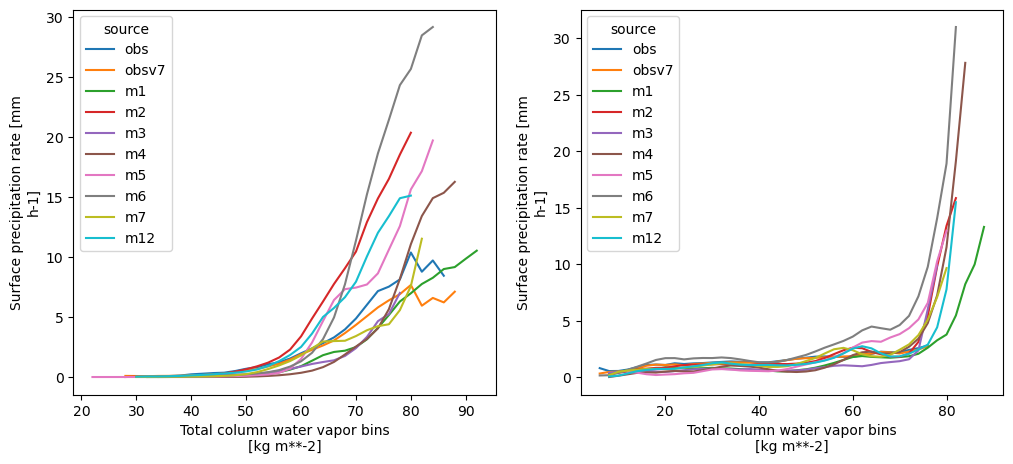

In [40]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
mcs_ocean_simtrack.plot.line(x='bins', ax=axes[0])
mcs_land_simtrack.plot.line(x='bins', ax=axes[1])

In [41]:
# Normalize the number of samples in each bin by the total sample
mcs_ocean_ns_dl = dse_dl.mcs_ocean_ns
total_ocean_ns_dl = dse_dl.total_ocean_ns
mcs_ocean_pdf_dl = mcs_ocean_ns_dl / mcs_ocean_ns_dl.sum(dim='bins')
total_ocean_pdf_dl = total_ocean_ns_dl / total_ocean_ns_dl.sum(dim='bins')

# Filter bins with insufficient samples
mcs_ocean_dl = dse_dl.mcs_ocean.where(mcs_ocean_pdf_dl > min_pdf_thresh)
total_ocean_dl = dse_dl.total_ocean.where(total_ocean_pdf_dl > min_pdf_thresh)

# Normalize the number of samples in each bin by the total sample
mcs_land_ns_dl = dse_dl.mcs_land_ns
total_land_ns_dl = dse_dl.total_land_ns
mcs_land_pdf_dl = mcs_land_ns_dl / mcs_land_ns_dl.sum(dim='bins')
total_land_pdf_dl = total_land_ns_dl / total_land_ns_dl.sum(dim='bins')

# Filter bins with insufficient samples
mcs_land_dl = dse_dl.mcs_land.where(mcs_land_pdf_dl > min_pdf_thresh)
total_land_dl = dse_dl.total_land.where(total_land_pdf_dl > min_pdf_thresh)

# Filter interquartile value bins with insufficient samples
mcs_ocean25_dl = dse_qrt.sel(tracker='DL').mcs_ocean_25.where(mcs_ocean_pdf_dl.sel(source='obs') > min_pdf_thresh)
mcs_ocean75_dl = dse_qrt.sel(tracker='DL').mcs_ocean_75.where(mcs_ocean_pdf_dl.sel(source='obs') > min_pdf_thresh)
mcs_land25_dl = dse_qrt.sel(tracker='DL').mcs_land_25.where(mcs_land_pdf_dl.sel(source='obs') > min_pdf_thresh)
mcs_land75_dl = dse_qrt.sel(tracker='DL').mcs_land_75.where(mcs_land_pdf_dl.sel(source='obs') > min_pdf_thresh)

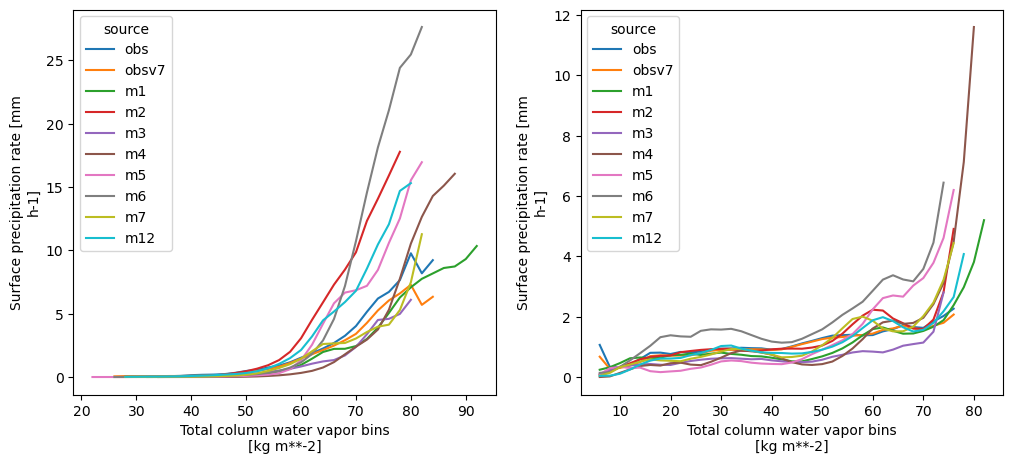

In [42]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
mcs_ocean_dl.plot.line(x='bins', ax=axes[0])
mcs_land_dl.plot.line(x='bins', ax=axes[1])

In [43]:
# Normalize the number of samples in each bin by the total sample
mcs_ocean_ns_kfyao = dse_kfyao.mcs_ocean_ns
total_ocean_ns_kfyao = dse_kfyao.total_ocean_ns
mcs_ocean_pdf_kfyao = mcs_ocean_ns_kfyao / mcs_ocean_ns_kfyao.sum(dim='bins')
total_ocean_pdf_kfyao = total_ocean_ns_kfyao / total_ocean_ns_kfyao.sum(dim='bins')

# Filter bins with insufficient samples
mcs_ocean_kfyao = dse_kfyao.mcs_ocean.where(mcs_ocean_pdf_kfyao > min_pdf_thresh)
total_ocean_kfyao = dse_kfyao.total_ocean.where(total_ocean_pdf_kfyao > min_pdf_thresh)

# Normalize the number of samples in each bin by the total sample
mcs_land_ns_kfyao = dse_kfyao.mcs_land_ns
total_land_ns_kfyao = dse_kfyao.total_land_ns
mcs_land_pdf_kfyao = mcs_land_ns_kfyao / mcs_land_ns_kfyao.sum(dim='bins')
total_land_pdf_kfyao = total_land_ns_kfyao / total_land_ns_kfyao.sum(dim='bins')

# Filter bins with insufficient samples
mcs_land_kfyao = dse_kfyao.mcs_land.where(mcs_land_pdf_kfyao > min_pdf_thresh)
total_land_kfyao = dse_kfyao.total_land.where(total_land_pdf_kfyao > min_pdf_thresh)

# Filter interquartile value bins with insufficient samples
mcs_ocean25_kfyao = dse_qrt.sel(tracker='KFyAO').mcs_ocean_25.where(mcs_ocean_pdf_kfyao.sel(source='obs') > min_pdf_thresh)
mcs_ocean75_kfyao = dse_qrt.sel(tracker='KFyAO').mcs_ocean_75.where(mcs_ocean_pdf_kfyao.sel(source='obs') > min_pdf_thresh)
mcs_land25_kfyao = dse_qrt.sel(tracker='KFyAO').mcs_land_25.where(mcs_land_pdf_kfyao.sel(source='obs') > min_pdf_thresh)
mcs_land75_kfyao = dse_qrt.sel(tracker='KFyAO').mcs_land_75.where(mcs_land_pdf_kfyao.sel(source='obs') > min_pdf_thresh)

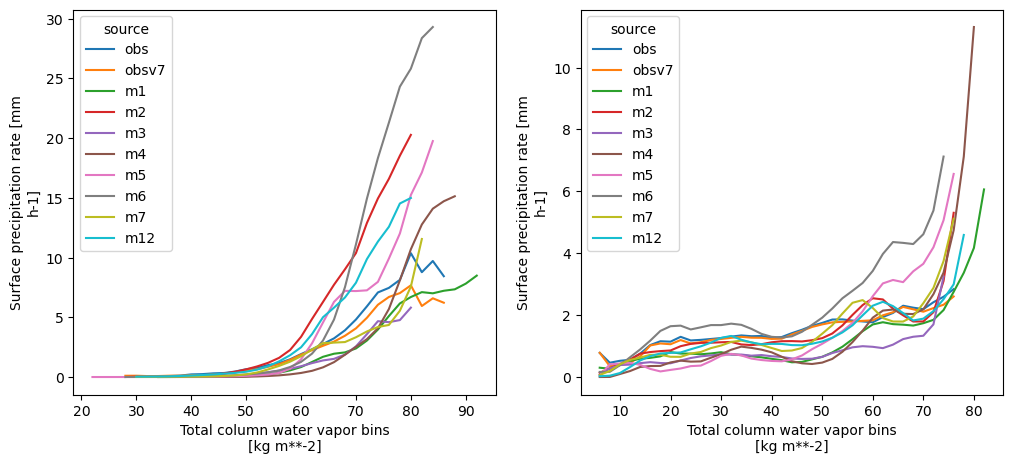

In [44]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
mcs_ocean_kfyao.plot.line(x='bins', ax=axes[0])
mcs_land_kfyao.plot.line(x='bins', ax=axes[1])

## Function to plot PWV vs. Precipitation for multiple trackers

In [45]:
def plot_lines_mxn(nrow, ncol, data_arr, xbin, qrt_arr,
                 titles=None, titles_loc=None, title_ha=None, xlabels=None, ylabels=None, xticks=None, legends=None, legend_loc=None, legend_ncol=None,
                 fontsize=None, legend_fontsize=None, legend_anchor=None, xlims=None, ylims=None, col_labels=None, wspace=None, hspace=None,
                 shade_dict=None, shade_qrt=None, draw_arrow=False, text_dict=None, figname=None, figsize=None, inset_flag=None):

    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    fig = plt.figure(figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(nrow, ncol)
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.95, wspace=wspace, hspace=hspace)
    
    lcolors = {
        'obs': 'k', 
        'obsv7': 'gray',
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
        'm12': 'dodgerblue',
    }
    lw = 1.5
    lws = {
        'obs': lw*3, 
        'obsv7': lw*2,
        'm1': lw,
        'm2': lw, 
        'm3': lw,
        'm4': lw,
        'm5': lw,
        'm6': lw,
        'm7': lw,
        'm8': lw,
        'm9': lw,
        'm10': lw,
        'm11': lw,
        'm12': lw,
    }
    
    # Loop over column and row
    for col in range(0, ncol):
        for row in range(0, nrow):
            ax = plt.subplot(gs[row,col])
            # Plot title for each column
            xmin, xmax = ax.get_xlim()
            xmid = (xmin + xmax)/2
            if row == 0:
                ax.text(xmid, 1.1, col_labels[col], fontsize=fontsize*1.5, ha='center', transform=ax.transAxes)

            # Share x-axis for all rows in each column
            if row < nrow - 1:
                # ax.get_xaxis().set_visible(False)
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(xlabels[col])
            
            # Plot data
            # Shade interquartile range
            if shade_qrt == True:
                iqrt = qrt_arr[row][col]
                if iqrt is not None:
                    ax.fill_between(xbin, iqrt[0], iqrt[1], facecolor='darkgray', alpha=0.5)
            
            for key in data_arr[row][col].source.data:
                idata = data_arr[row][col].sel(source=key)
                ax.plot(xbin, idata, lcolors[key], lw=lws[key], label=legends[key])
                # yspan = (ylims[col][1] - ylims[col][0])
                # amp = amp_arr[row][col][key] * amp_scale[col]  # scale the diurnal amplitude
                # # Plot diurnal phase and amplitude
                # ax.scatter(phs_arr[row][col][key], ylims[col][0]+yspan*0.01, s=15, marker='^', facecolor=lcolors[key])
                # ax.axvline(phs_arr[row][col][key], ymax=ylims[col][0]+amp, color=lcolors[key], lw=lws[key])
            ax.axvline(x=0, lw=1, ls='--', color='k')
            ax.grid(which='major', ls='--', lw=0.5)
            # ax.set_xlabel(xlabels[row][col])
            if ylabels is not None: ax.set_ylabel(ylabels[row][col])
            if xticks is not None: ax.set_xticks(xticks[col])
            if ylims is not None: ax.set_ylim(ylims[col][0], ylims[col][1])
            if xlims is not None: ax.set_xlim(xlims[col][0], xlims[col][1])
            # ax.set_title(titles[row][col], loc='left')
            # Make title within the axis
            flabel = ax.text(titles_loc[0], titles_loc[1], titles[row][col], ha=title_ha, transform=ax.transAxes, fontsize=fontsize)
            flabel.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
            if (row == 0) & (col == ncol-1):
                ax.legend(fontsize=legend_fontsize, loc=legend_loc, ncol=legend_ncol, bbox_to_anchor=legend_anchor)
                # ax.legend(fontsize=legend_fontsize, loc=legend_loc[col], ncol=legend_ncol[col])
            # Fill background color
            if shade_dict:
                # xmin, xmax = ax.get_xlim()
                ax.axvspan(shade_dict['xmin'], shade_dict['xmax'], facecolor=shade_dict['color'], alpha=shade_dict['alpha'], transform=ax.get_xaxis_transform())
                # ax.text(titles_loc[0], titles_loc[1], titles[row][col], ha=title_ha, transform=ax.transAxes, fontsize=fontsize)
                
            # Draw an arrow to show the direction of time increase
            if (draw_arrow) & (row == nrow-1):
                ax.annotate('', xy=(1, -0.3), xytext=(0, -0.3), xycoords='axes fraction',
                            arrowprops=dict(arrowstyle="->", facecolor='k', lw=3))
    # Add text to figure
    if text_dict is not None:
        fig.text(text_dict['x'], text_dict['y'], text_dict['text'], ha=text_dict['ha'], va=text_dict['va'], fontsize=text_dict['fontsize'])

    fig.savefig(figname, dpi=300, facecolor='w', bbox_inches='tight')
    return fig

In [46]:
if PHASE == 'Summer':
    panel_numbers = ['(a)', '(b)', ]
elif PHASE == 'Winter':
    panel_numbers = ['(c)', '(d)', ]
print(panel_numbers)

['(a)', '(b)']


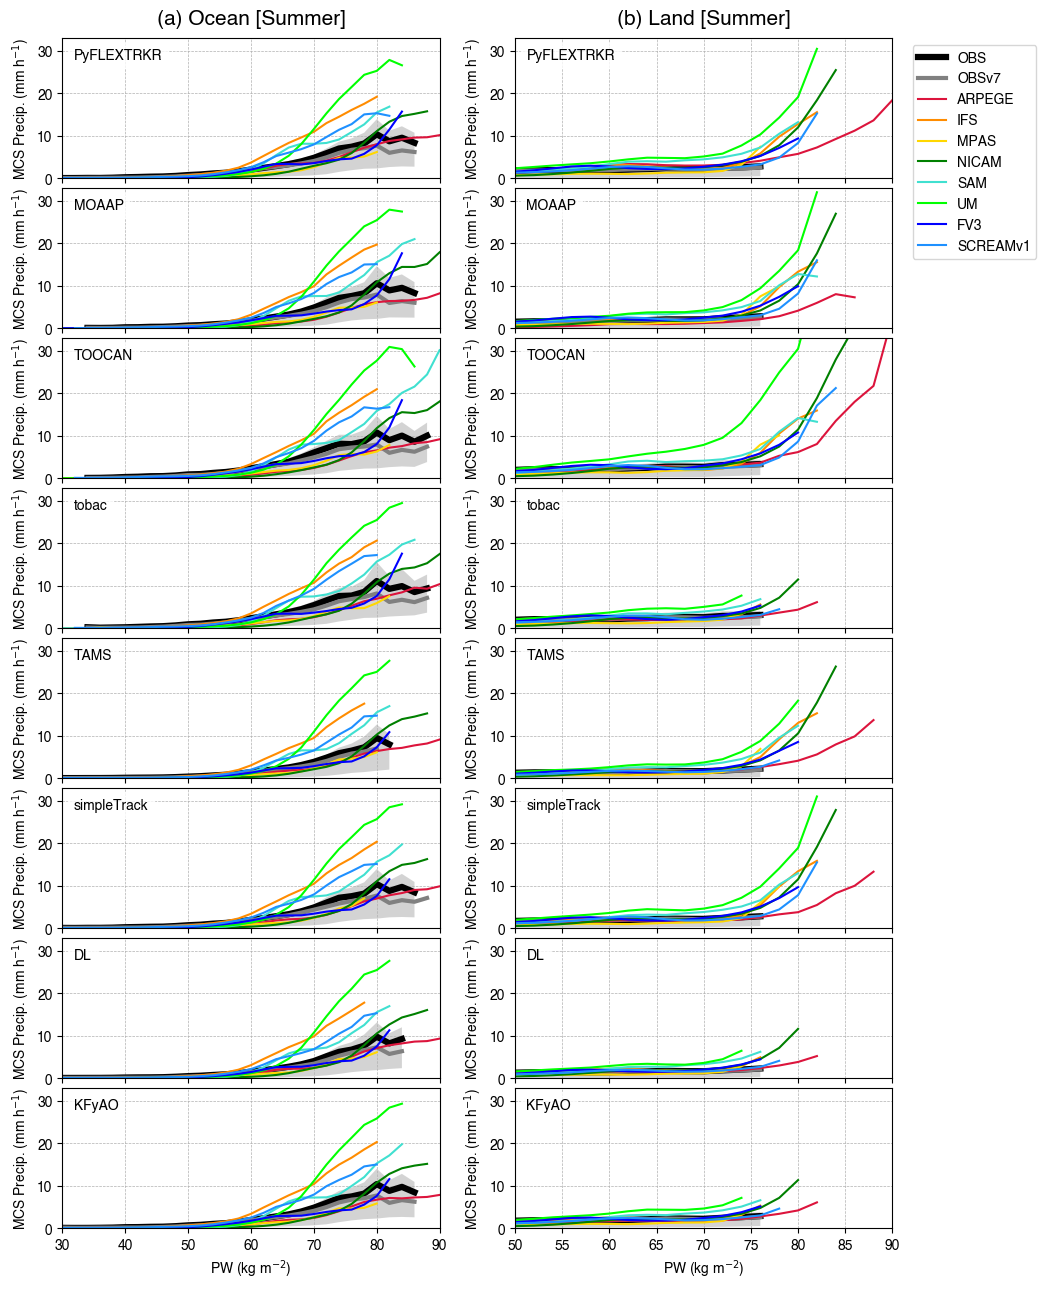

In [47]:
# Data array [row][col]
data_arr = [
    [mcs_ocean_pyflex, mcs_land_pyflex],
    [mcs_ocean_moaap, mcs_land_moaap],
    [mcs_ocean_toocan, mcs_land_toocan],
    [mcs_ocean_tobac, mcs_land_tobac],
    [mcs_ocean_tams, mcs_land_tams],
    [mcs_ocean_simtrack, mcs_land_simtrack],
    [mcs_ocean_dl, mcs_land_dl],
    [mcs_ocean_kfyao, mcs_land_kfyao],
]
qrt_arr = [
    [(mcs_ocean25_pyflex, mcs_ocean75_pyflex), (mcs_land25_pyflex, mcs_land75_pyflex)],
    [(mcs_ocean25_moaap, mcs_ocean75_moaap), (mcs_land25_moaap, mcs_land75_moaap)],
    [(mcs_ocean25_toocan, mcs_ocean75_toocan), (mcs_land25_toocan, mcs_land75_toocan)],
    [(mcs_ocean25_tobac, mcs_ocean75_tobac), (mcs_land25_tobac, mcs_land75_tobac)],
    [(mcs_ocean25_tams, mcs_ocean75_tams), (mcs_land25_tams, mcs_land75_tams)],
    [(mcs_ocean25_simtrack, mcs_ocean75_simtrack), (mcs_land25_simtrack, mcs_land75_simtrack)],
    [(mcs_ocean25_dl, mcs_ocean75_dl), (mcs_land25_dl, mcs_land75_dl)],
    [(mcs_ocean25_kfyao, mcs_ocean75_kfyao), (mcs_land25_kfyao, mcs_land75_kfyao)],
]
xbin = mcs_ocean_pyflex.bins
legends = name_map
nrow = len(data_arr)
ncol = 2
col_labels = [f'{panel_numbers[0]} Ocean [{PHASE}]', f'{panel_numbers[1]} Land [{PHASE}]']
titles = [
    ['PyFLEXTRKR', 'PyFLEXTRKR',],
    ['MOAAP', 'MOAAP',],
    ['TOOCAN', 'TOOCAN',],
    ['tobac', 'tobac',],
    ['TAMS', 'TAMS'],
    ['simpleTrack', 'simpleTrack'],
    ['DL', 'DL'],
    ['KFyAO', 'KFyAO'],
]
titles_loc = [0.03, 0.85]
title_ha = 'left'
xlabels = ['PW (kg m$^{-2}$)','PW (kg m$^{-2}$)']
ylabels = [['MCS Precip. (mm h$^{-1}$)', 'MCS Precip. (mm h$^{-1}$)']] * nrow
xticks = None
xlims = [(30,90),(50,90)]
ylims = [(0,33),(0,33)]
legend_loc = 'upper right'
legend_ncol = 1
legend_anchor = (1.4, 1)
fontsize = 10
legend_fontsize = 10
# figsize = [10,12]
# figsize = [10,13]
figsize = [10,14]
wspace = 0.20
hspace = 0.07
# text_dict = {'text': f'{diameter_km:.0f}km', 'x': 1.0, 'y':0.96, 'ha':'right', 'va':'center', 'fontsize':fontsize*1.5}
text_dict = None
# shade_dict = {'xmin':60, 'xmax':70, 'color':'lightskyblue', 'alpha':0.2}
shade_dict = None
figname = f'{figdir}mcs_pwv_collocated_ocean_land_all.png'

fig = plot_lines_mxn(nrow, ncol, data_arr, xbin, qrt_arr, 
                   titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
                   fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, col_labels=col_labels, wspace=wspace, hspace=hspace,
                   shade_qrt=True, draw_arrow=False, text_dict=text_dict, figname=figname, figsize=figsize)

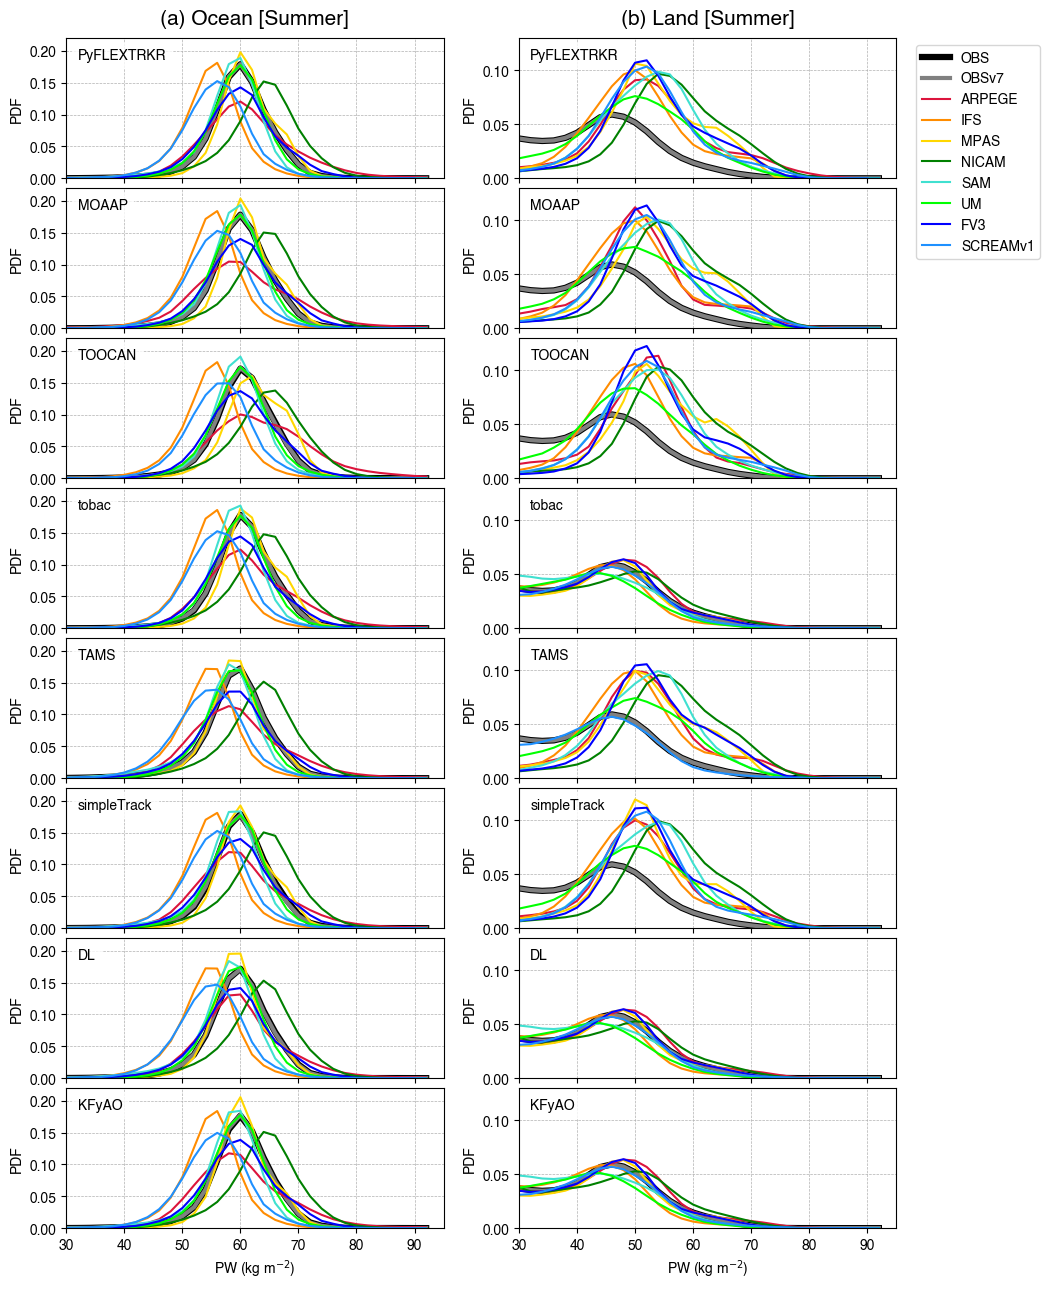

In [48]:
# Data array [row][col]
data_arr = [
    [mcs_ocean_pdf_pyflex, mcs_land_pdf_pyflex],
    [mcs_ocean_pdf_moaap, mcs_land_pdf_moaap],
    [mcs_ocean_pdf_toocan, mcs_land_pdf_toocan],
    [mcs_ocean_pdf_tobac, mcs_land_pdf_tobac],
    [mcs_ocean_pdf_tams, mcs_land_pdf_tams],
    [mcs_ocean_pdf_simtrack, mcs_land_pdf_simtrack],
    [mcs_ocean_pdf_dl, mcs_land_pdf_dl],
    [mcs_ocean_pdf_kfyao, mcs_land_pdf_kfyao],
]
xbin = mcs_ocean_pyflex.bins
legends = name_map
nrow = len(data_arr)
ncol = 2
col_labels = [f'{panel_numbers[0]} Ocean [{PHASE}]', f'{panel_numbers[1]} Land [{PHASE}]']
titles = [
    ['PyFLEXTRKR', 'PyFLEXTRKR',],
    ['MOAAP', 'MOAAP',],
    ['TOOCAN', 'TOOCAN',],
    ['tobac', 'tobac',],
    ['TAMS', 'TAMS'],
    ['simpleTrack', 'simpleTrack'],
    ['DL', 'DL'],
    ['KFyAO', 'KFyAO'],
]
titles_loc = [0.03, 0.85]
title_ha = 'left'
xlabels = ['PW (kg m$^{-2}$)','PW (kg m$^{-2}$)']
ylabels = [['PDF', 'PDF']] * nrow
xticks = None
xlims = [(30,95),(30,95)]
ylims = [(0,0.22),(0,0.13)]
# ylims = None
legend_loc = 'upper right'
legend_ncol = 1
legend_anchor = (1.4, 1)
fontsize = 10
legend_fontsize = 10
# figsize = [10,12]
# figsize = [10,13]
figsize = [10,14]
wspace = 0.20
hspace = 0.07
# text_dict = {'text': f'{diameter_km:.0f}km', 'x': 1.0, 'y':0.96, 'ha':'right', 'va':'center', 'fontsize':fontsize*1.5}
text_dict = None
# shade_dict = {'xmin':60, 'xmax':70, 'color':'lightskyblue', 'alpha':0.2}
shade_dict = None
figname = f'{figdir}mcs_pwv_pdf_ocean_land_all.png'

fig = plot_lines_mxn(nrow, ncol, data_arr, xbin, qrt_arr,
                   titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
                   fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, col_labels=col_labels, wspace=wspace, hspace=hspace,
                   shade_qrt=False, draw_arrow=False, text_dict=text_dict, figname=figname, figsize=figsize)

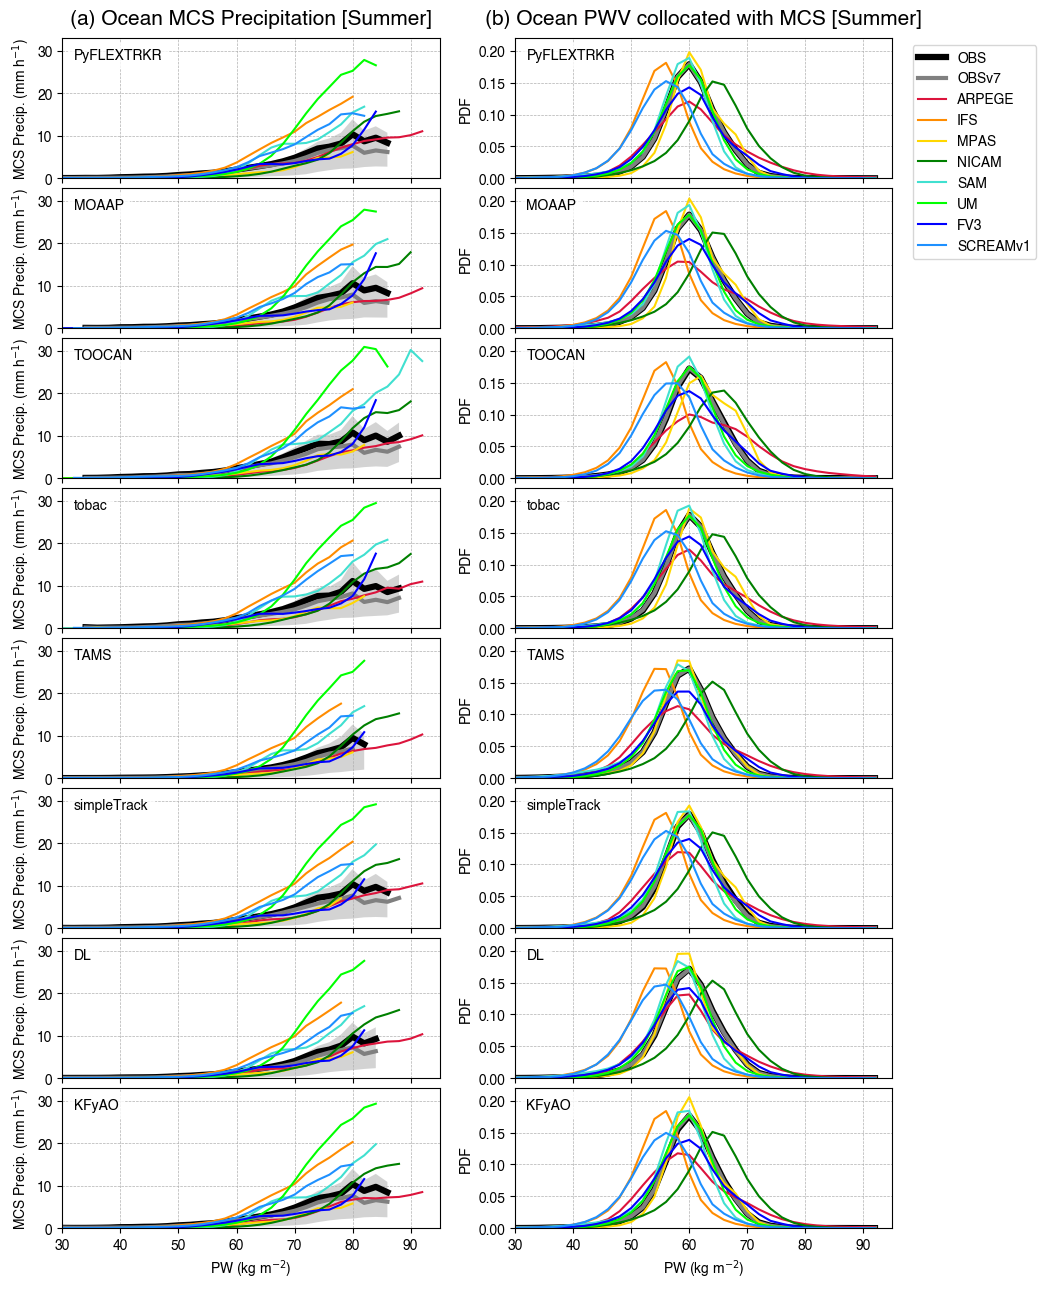

In [49]:
# Data array [row][col]
data_arr = [
    [mcs_ocean_pyflex, mcs_ocean_pdf_pyflex],
    [mcs_ocean_moaap, mcs_ocean_pdf_moaap],
    [mcs_ocean_toocan, mcs_ocean_pdf_toocan],
    [mcs_ocean_tobac, mcs_ocean_pdf_tobac],
    [mcs_ocean_tams, mcs_ocean_pdf_tams],
    [mcs_ocean_simtrack, mcs_ocean_pdf_simtrack],
    [mcs_ocean_dl, mcs_ocean_pdf_dl],
    [mcs_ocean_kfyao, mcs_ocean_pdf_kfyao],
]
qrt_arr = [
    [(mcs_ocean25_pyflex, mcs_ocean75_pyflex), None],
    [(mcs_ocean25_moaap, mcs_ocean75_moaap), None],
    [(mcs_ocean25_toocan, mcs_ocean75_toocan), None],
    [(mcs_ocean25_tobac, mcs_ocean75_tobac), None],
    [(mcs_ocean25_tams, mcs_ocean75_tams), None],
    [(mcs_ocean25_simtrack, mcs_ocean75_simtrack), None],
    [(mcs_ocean25_dl, mcs_ocean75_dl), None],
    [(mcs_ocean25_kfyao, mcs_ocean75_kfyao), None],
]
xtime = mcs_ocean_pyflex.bins
legends = name_map
nrow = len(data_arr)
ncol = 2
col_labels = [f'{panel_numbers[0]} Ocean MCS Precipitation [{PHASE}]', f'{panel_numbers[1]} Ocean PWV collocated with MCS [{PHASE}]']
titles = [
    ['PyFLEXTRKR', 'PyFLEXTRKR',],
    ['MOAAP', 'MOAAP',],
    ['TOOCAN', 'TOOCAN',],
    ['tobac', 'tobac',],
    ['TAMS', 'TAMS'],
    ['simpleTrack', 'simpleTrack'],
    ['DL', 'DL'],
    ['KFyAO', 'KFyAO'],
]
titles_loc = [0.03, 0.85]
title_ha = 'left'
xlabels = ['PW (kg m$^{-2}$)','PW (kg m$^{-2}$)']
ylabels = [['MCS Precip. (mm h$^{-1}$)', 'PDF']] * nrow
xticks = None
xlims = [(30,95),(30,95)]
ylims = [(0,33),(0,0.22)]
# ylims = None
legend_loc = 'upper right'
legend_ncol = 1
legend_anchor = (1.4, 1)
fontsize = 10
legend_fontsize = 10
# figsize = [10,12]
# figsize = [10,13]
figsize = [10,14]
wspace = 0.20
hspace = 0.07
# text_dict = {'text': f'{diameter_km:.0f}km', 'x': 1.0, 'y':0.96, 'ha':'right', 'va':'center', 'fontsize':fontsize*1.5}
text_dict = None
# shade_dict = {'xmin':60, 'xmax':70, 'color':'lightskyblue', 'alpha':0.2}
shade_dict = None
figname = f'{figdir}mcs_pwv_collocated_ocean_all.png'

fig = plot_lines_mxn(nrow, ncol, data_arr, xtime, qrt_arr,
                   titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
                   fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, col_labels=col_labels, wspace=wspace, hspace=hspace,
                   shade_qrt=True, draw_arrow=False, text_dict=text_dict, figname=figname, figsize=figsize)

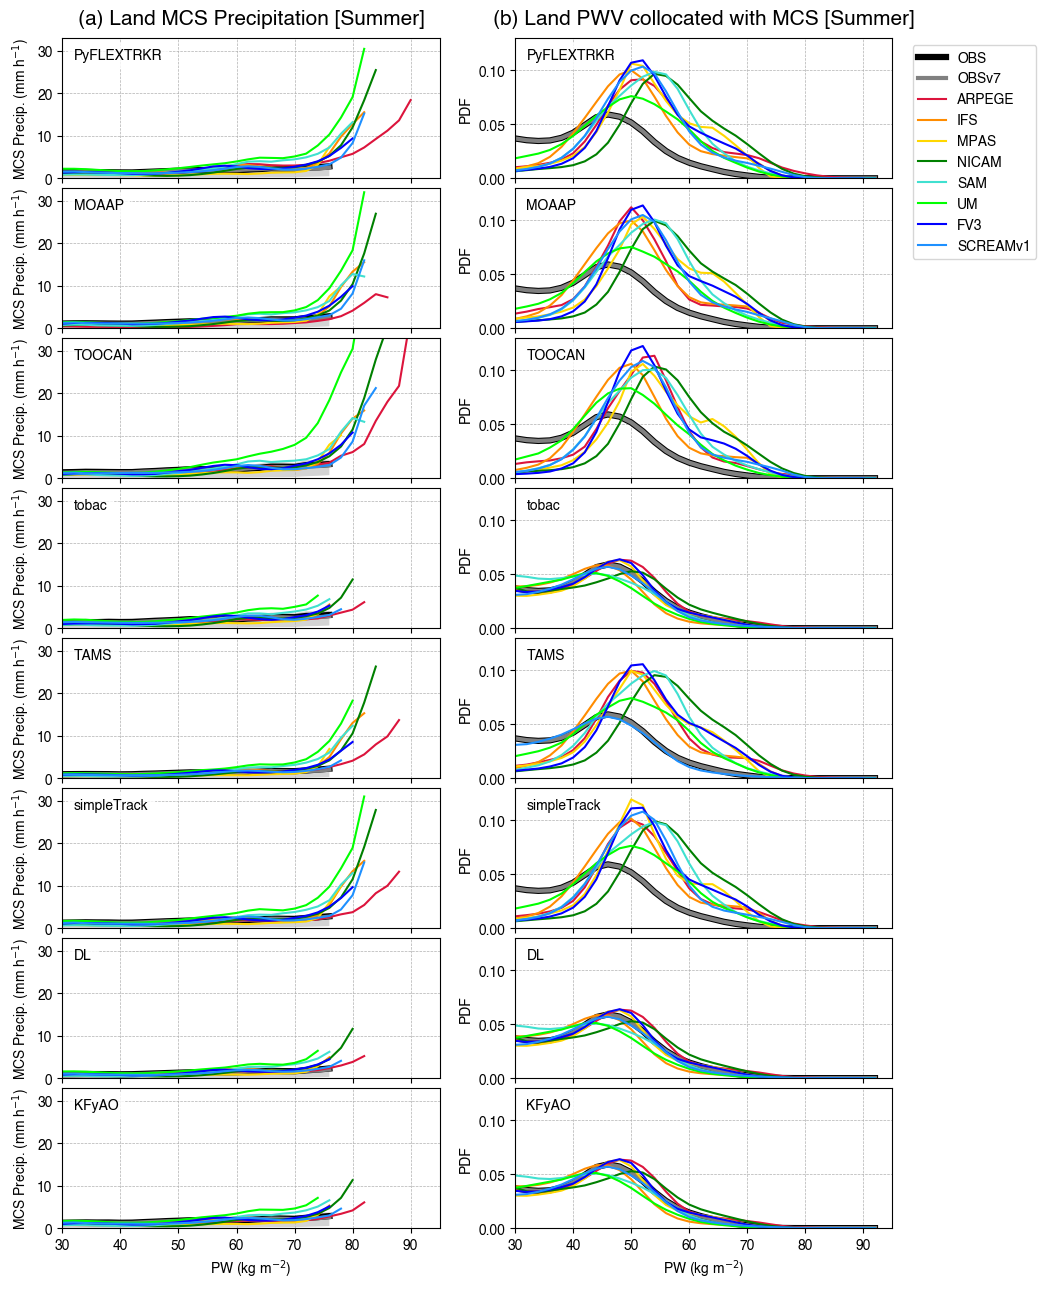

In [50]:
# Data array [row][col]
data_arr = [
    [mcs_land_pyflex, mcs_land_pdf_pyflex],
    [mcs_land_moaap, mcs_land_pdf_moaap],
    [mcs_land_toocan, mcs_land_pdf_toocan],
    [mcs_land_tobac, mcs_land_pdf_tobac],
    [mcs_land_tams, mcs_land_pdf_tams],
    [mcs_land_simtrack, mcs_land_pdf_simtrack],
    [mcs_land_dl, mcs_land_pdf_dl],
    [mcs_land_kfyao, mcs_land_pdf_kfyao],
]
qrt_arr = [
    [(mcs_land25_pyflex, mcs_land75_pyflex), None],
    [(mcs_land25_moaap, mcs_land75_moaap), None],
    [(mcs_land25_toocan, mcs_land75_toocan), None],
    [(mcs_land25_tobac, mcs_land75_tobac), None],
    [(mcs_land25_tams, mcs_land75_tams), None],
    [(mcs_land25_simtrack, mcs_land75_simtrack), None],
    [(mcs_land25_dl, mcs_land75_dl), None],
    [(mcs_land25_kfyao, mcs_land75_kfyao), None],
]
xtime = mcs_land_pyflex.bins
legends = name_map
nrow = len(data_arr)
ncol = 2
# col_labels = ['Land MCS Precipitation', 'Land PWV collocated with MCS']
col_labels = [f'{panel_numbers[0]} Land MCS Precipitation [{PHASE}]', f'{panel_numbers[1]} Land PWV collocated with MCS [{PHASE}]']
titles = [
    ['PyFLEXTRKR', 'PyFLEXTRKR',],
    ['MOAAP', 'MOAAP',],
    ['TOOCAN', 'TOOCAN',],
    ['tobac', 'tobac',],
    ['TAMS', 'TAMS'],
    ['simpleTrack', 'simpleTrack'],
    ['DL', 'DL'],
    ['KFyAO', 'KFyAO'],
]
titles_loc = [0.03, 0.85]
title_ha = 'left'
xlabels = ['PW (kg m$^{-2}$)','PW (kg m$^{-2}$)']
ylabels = [['MCS Precip. (mm h$^{-1}$)', 'PDF']] * nrow
xticks = None
xlims = [(30,95),(30,95)]
ylims = [(0,33),(0,0.13)]
# ylims = None
legend_loc = 'upper right'
legend_ncol = 1
legend_anchor = (1.4, 1)
fontsize = 10
legend_fontsize = 10
# figsize = [10,12]
# figsize = [10,13]
figsize = [10,14]
wspace = 0.20
hspace = 0.07
# text_dict = {'text': f'{diameter_km:.0f}km', 'x': 1.0, 'y':0.96, 'ha':'right', 'va':'center', 'fontsize':fontsize*1.5}
text_dict = None
# shade_dict = {'xmin':60, 'xmax':70, 'color':'lightskyblue', 'alpha':0.2}
shade_dict = None
figname = f'{figdir}mcs_pwv_collocated_land_all.png'

fig = plot_lines_mxn(nrow, ncol, data_arr, xtime, qrt_arr,
                   titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
                   fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, col_labels=col_labels, wspace=wspace, hspace=hspace,
                   shade_qrt=True, draw_arrow=False, text_dict=text_dict, figname=figname, figsize=figsize)